# Import

In [15]:
import os
import pydub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Steps taken before this experiment
Found the ground truth bpm of 'Never gonna give you up' and stored it in a text document along with the song name. I will plan to store these with each album, but for now ground truths will be labeled with **GT**

# Current Proposed Methods
- Low Pass filter and find peaks in bass
- Calculate the entropy of music
- Perform filtering on all of it
# Previous Publications of interest
- https://www.researchgate.net/publication/228987153_Detection_of_Spirited_Incidental_Music_in_Movies

# Idea 1: Calculate Peaks by filtering amplitude

## Load song information from txt

In [1]:
# State path to text file
gt_file_path = '../../Artists/Rick Astley/NotLabeled/Rick_Astley_BPM_GT.txt'
# Check to see if it exists
os.path.exists(gt_file_path)

True

In [7]:
# Load it into a pandas dataframe
df = pd.read_csv(gt_file_path)
df.head()

,Song,BPM
0,Rick Astley - Never Gonna Give You Up (Officia...,113


## Load song

In [9]:
song_path = '../../Artists/Rick Astley/NotLabeled/Rick Astley - Never Gonna Give You Up (Official Music Video).mp3'
os.path.exists(song_path)

True

In [11]:
song = pydub.AudioSegment.from_mp3(song_path)

In [196]:
from pydub.silence import detect_nonsilent

def remove_sil(sound):
    non_sil_times = detect_nonsilent(sound, min_silence_len=50, silence_thresh=sound.dBFS * 1.5)
    if len(non_sil_times) > 0:
        non_sil_times_concat = [non_sil_times[0]]
        if len(non_sil_times) > 1:
            for t in non_sil_times[1:]:
                if t[0] - non_sil_times_concat[-1][-1] < 200:
                    non_sil_times_concat[-1][-1] = t[1]
                else:
                    non_sil_times_concat.append(t)
        non_sil_times = [t for t in non_sil_times_concat if t[1] - t[0] > 350]
        return(sound[non_sil_times[0][0]: non_sil_times[-1][1]])


## Get Amplitude Data

In [369]:
def get_amplitudes(track, interval=5):
    '''
    Inputs:
        - track: a pydub audio segmentation file
        - interval: sampling rate of the track
    
    Ouputs
        - times_wanted
        - amplitudes
    '''
    amplitudes = []
    track_length = len(track)
    times_wanted = np.arange(0, track_length, interval*1000)

    for x in times_wanted:
        amplitude = track[x].max
        amplitudes.append(amplitude)

    return(times_wanted, amplitudes)

In [370]:
times, amps = get_amplitudes(song,1)

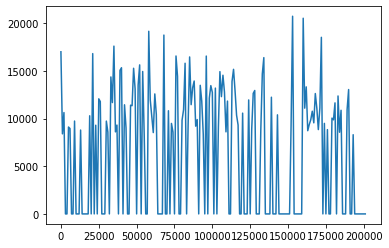

In [430]:
plt.plot(times, amps)

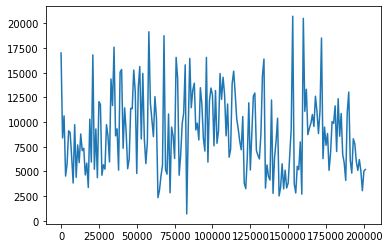

In [462]:
# song_cut_down = remove_sil(song)
# times, amps = get_amplitudes(song_cut_down,1)
# plt.plot(times, amps)

## Perform Thresholding

In [463]:
# Prefiltering
amps = [0 if amps_ == float('-inf') else amps_ for amps_ in amps]
# Get max
max_amp = np.max(amps)
# Get min
min_amp = np.min(amps)
# Get average
avg_amp = np.average(amps)
# Print
print(max_amp)
print(min_amp)
print(avg_amp)

20735
690
8968.460396039603


In [471]:
# Calculate 75% threshold
# seventyfive = int(0.35*max_amp)
seventyfive = 10000
print(seventyfive)

10000


In [472]:
# Apply it 
print(amps[5:20])
amps = [0 if amps_ < seventyfive else amps_ for amps_ in amps]
print(amps[5:20])

[9114, 8954, 0, 0, 9742, 0, 7680, 0, 8797, 0, 7349, 0, 0, 0, 10294]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10294]


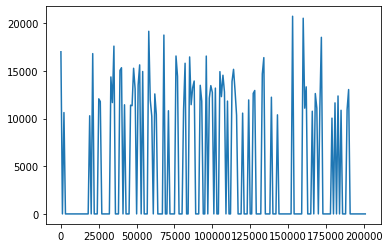

In [473]:
plt.plot(times, amps)

## Calculate the number of seconds between loud beats

In [474]:
beat_occur_times = []
i = 0
for time,amp in zip(times,amps):
    if amp != 0:
        beat_occur_times.append(time/1000)
    i+=1

print(beat_occur_times[0:50])

[0.0, 2.0, 19.0, 21.0, 25.0, 26.0, 33.0, 34.0, 35.0, 39.0, 40.0, 42.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 54.0, 58.0, 59.0, 60.0, 62.0, 63.0, 68.0, 71.0, 76.0, 77.0, 81.0, 82.0, 85.0, 86.0, 87.0, 88.0, 92.0, 93.0, 96.0, 98.0, 99.0, 100.0, 102.0, 105.0, 106.0, 107.0, 108.0, 110.0, 113.0, 114.0, 115.0, 116.0]


In [475]:
delta_time = []
for x,y in zip(beat_occur_times[0::], beat_occur_times[1::]):
    delta_time.append(y-x)

print(delta_time[0:10])
np.average(delta_time)

[2.0, 17.0, 2.0, 4.0, 1.0, 7.0, 1.0, 1.0, 4.0, 1.0]


2.638888888888889

In [476]:
print(np.average(delta_time))
print(np.average(delta_time)*60)
print(np.median(delta_time))
print(np.median(delta_time)*60)


2.638888888888889
158.33333333333334
2.0
120.0


In [478]:
### Write a loop to find the best filter
list_frequencies = np.arange(1000, 20000, 1000)
for x in list_frequencies:
    times, amps = get_amplitudes(song,1)
    
    
    

array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000])

### Two methods: 1) compare the length of loud amplitudes

In [289]:
len(song)/len(beat_occur_times)

1060.455